In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import pandas as pd
import matplotlib.dates as mdates

In [2]:
output_1h_solar = np.genfromtxt('test_results/outputs_solar_1h.csv', delimiter=',')
output_24h_solar = np.genfromtxt('test_results/solar_outputs_24h.csv', delimiter=',')
output_1h_wind = np.genfromtxt('test_results/wind_outputs_1h.csv', delimiter=',')
output_24h_wind = np.genfromtxt('test_results/outputs_wind_24h.csv', delimiter=',')

target_1h_solar = np.genfromtxt('test_results/targets_solar_1h.csv', delimiter=',')
target_24h_solar = np.genfromtxt('test_results/solar_targets_24h.csv', delimiter=',')
target_1h_wind = np.genfromtxt('test_results/wind_targets_1h.csv', delimiter=',')
target_24h_wind = np.genfromtxt('test_results/targets_wind_24h.csv', delimiter=',')

In [3]:
wind_unnorm = np.genfromtxt('data/test_data/test_wind_unnorm2.csv', delimiter=',',skip_header=1)
#get first column of wind_unnorm
wind_unnorm = wind_unnorm[:,0]
wind_max = np.max(wind_unnorm)
wind_min = np.min(wind_unnorm)
solar_unnorm = np.genfromtxt('data/test_data/test_solar_unnorm2.csv', delimiter=',',skip_header=1)
#get first column of solar_unnorm
solar_unnorm = solar_unnorm[:,0]
solar_max = np.max(solar_unnorm)
solar_min = np.min(solar_unnorm)
print('wind max: ', wind_max, 'wind min: ', wind_min)
print('solar max: ', solar_max, 'solar min: ', solar_min)

wind max:  45311.34872868136 wind min:  819.3663645944786
solar max:  25902.838301431104 solar min:  0.0


In [4]:
# invert normalization of data to range [-1, 1]
def invert_minmax_scaling(predictions, target_min, target_max):
    return ((predictions + 1) / 2) * (target_max - target_min) + target_min

In [5]:
#unnormalize the data
output_1h_solar = invert_minmax_scaling(output_1h_solar, solar_min, solar_max)
output_24h_solar = invert_minmax_scaling(output_24h_solar, solar_min, solar_max)
output_1h_wind = invert_minmax_scaling(output_1h_wind, wind_min, wind_max)
output_24h_wind = invert_minmax_scaling(output_24h_wind, wind_min, wind_max)
target_1h_solar = invert_minmax_scaling(target_1h_solar, solar_min, solar_max)
target_24h_solar = invert_minmax_scaling(target_24h_solar, solar_min, solar_max)
target_1h_wind = invert_minmax_scaling(target_1h_wind, wind_min, wind_max)
target_24h_wind = invert_minmax_scaling(target_24h_wind, wind_min, wind_max)


In [6]:
output_solar_1h = np.genfromtxt('outputs.csv', delimiter=',')
targets_solar_1h = np.genfromtxt('targets.csv', delimiter=',')
# get min and max values of solar data
#max = np.max(output_solar_1h)
#min = np.min(output_solar_1h)
#print('max: ', max, 'min: ', min)
#print('max: ', np.max(targets_solar_1h), 'min: ', np.min(targets_solar_1h)) 

FileNotFoundError: outputs.csv not found.

In [ ]:
outputs_wind_1h = np.genfromtxt('outputs_wind.csv', delimiter=',')
targets_wind_1h = np.genfromtxt('targets_wind.csv', delimiter=',')
# get min and max values of wind data
#max = np.max(outputs_wind_1h)
#min = np.min(outputs_wind_1h)
print('max: ', max, 'min: ', min)
print('max: ', np.max(targets_wind_1h), 'min: ', np.min(targets_wind_1h))

max:  <built-in function max> min:  <built-in function min>
max:  124607976.0 min:  0.0


In [ ]:
def plot_day(output_1h, output_24h, target, subject): 
    hours_per_day = 24
    sequence_length_1h = 25  # Sequence length for 1-hour predictions
    sequence_length_24h = 72  # Sequence length for 24-hour predictions

    # Calculate the maximum index from which we can start plotting to ensure we have enough data
    max_day_index = min(len(output_1h) - sequence_length_1h, len(output_24h) - sequence_length_24h)

    # Randomly select a start hour within the appropriate range
    start_hour = np.random.randint(0, max_day_index + 1)

    plt.figure(figsize=(12, 6))
    # Plot the target data for the selected day
    plt.plot(range(hours_per_day), target[start_hour + max(sequence_length_1h, sequence_length_24h):start_hour + max(sequence_length_1h, sequence_length_24h) + hours_per_day], "-o", color="b", label="Actual", markersize=4)
    # Plot 1-hour ahead predictions
    plt.plot(range(hours_per_day), output_1h[start_hour + sequence_length_1h:start_hour + sequence_length_1h + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=4)
    # Plot 24-hour ahead predictions
    plt.plot(range(hours_per_day), output_24h[start_hour + sequence_length_24h:start_hour + sequence_length_24h + hours_per_day], "-o", color="purple", label="Predictions (24hr ahead)", markersize=4)
    print('start_hour: ', start_hour)
    
    plt.legend()
    plt.title(f"{subject} Energy Supply: Day {(start_hour // 24) + 1} of 2022")
    plt.xlabel("Hour of the Day")
    plt.ticklabel_format(axis="y", style="plain")
    plt.ylabel(f"{subject} Supply MW")
    plt.grid(True)
    plt.savefig(f"plots/testing/{subject}_energy_supply_day_{(start_hour // 24) + 1}.png")
    plt.show()

In [ ]:
#plot_day(output_1h_solar, output_24h_solar, target_1h_solar, "Solar")
#plot_day(output_1h_wind, output_24h_wind, target_1h_wind, "Wind")


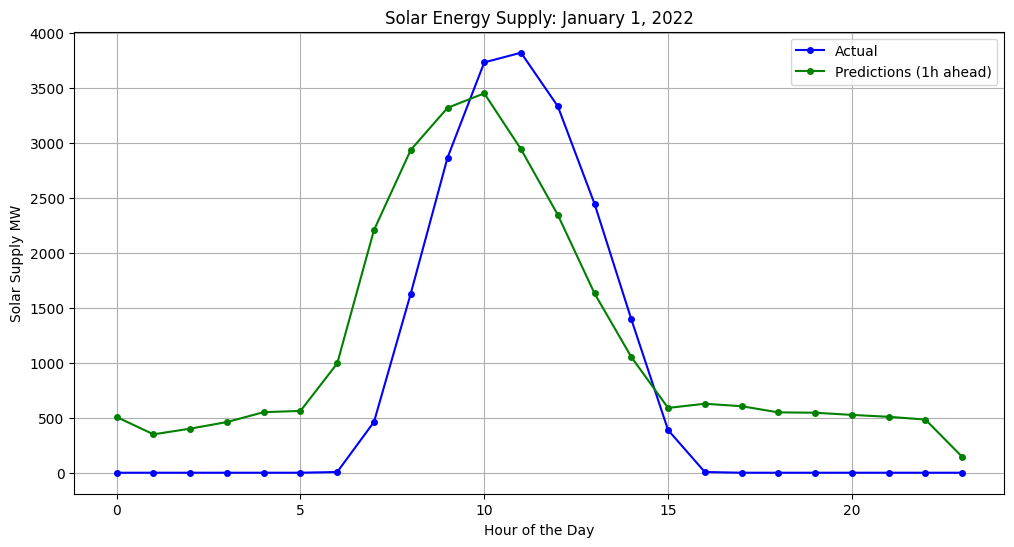

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_specific_day(output_1h, output_24h, target, subject, day_index):
    hours_per_day = 24
    sequence_length_1h = 25  # Sequence length for 1-hour predictions
    sequence_length_24h = 72  # Sequence length for 24-hour predictions

    plt.figure(figsize=(12, 6))

    # Calculate starting hour of the day for plotting (offset by the maximum sequence length to handle predictions)
    start_hour = day_index * hours_per_day - max(sequence_length_1h, sequence_length_24h)

    if start_hour < 0:
        raise ValueError("Starting hour for plotting falls before the start of the dataset")

    # Plot the target data for the selected day
    plt.plot(range(hours_per_day), target[start_hour + max(sequence_length_1h, sequence_length_24h):start_hour + max(sequence_length_1h, sequence_length_24h) + hours_per_day], "-o", color="b", label="Actual", markersize=4)
    # Plot 1-hour ahead predictions
    plt.plot(range(hours_per_day), output_1h[start_hour + sequence_length_1h:start_hour + sequence_length_1h + hours_per_day], "-o", color="g", label="Predictions (1h ahead)", markersize=4)
    # Plot 24-hour ahead predictions
    #plt.plot(range(hours_per_day), output_24h[start_hour + sequence_length_24h:start_hour + sequence_length_24h + hours_per_day], "-o", color="purple", label="Predictions (24hr ahead)", markersize=4)

    plt.legend()
    plt.title(f"{subject} Energy Supply: January 1, 2022")
    plt.xlabel("Hour of the Day")
    plt.ticklabel_format(axis="y", style="plain")
    plt.ylabel(f"{subject} Supply MW")
    plt.grid(True)
    #plt.savefig(f"plots/testing/{subject}_energy_supply_January_1_2022.png")
    plt.show()

# Call the function with the appropriate indices for January 1, 2022 (day_index = 0 since January 1 is the first day of the year)
plot_specific_day(output_1h_solar, output_24h_solar, target_1h_solar, "Solar", day_index=32)


In [ ]:
def plot_week(output_1h, output_24h, target, subject):
    # Number of hours per week
    hours_per_week = 7 * 24

    # Adjust start hour for plotting from hour 24 to align all datasets
    # Reducing the maximum index calculation by 24 hours to accommodate the offset for synced data
    max_week_index = len(output_24h) - hours_per_week  # Use outputs_solar_24 length to define the week's limits

    # Select a random start hour from 24 to the maximum possible index that still allows for a full week of data
    start_hour = np.random.randint(24, max_week_index + 1)

    # Calculate the corresponding week number (for title purposes)
    week_number = (start_hour - 24) // hours_per_week + 1

    # Plot actual vs. predicted solar energy outputs for the selected week, starting from the 24th hour
    plt.figure(figsize=(12, 6))
    plt.plot(range(hours_per_week), target[start_hour:start_hour + hours_per_week], "-o", color="b", label="Actual", markersize=2)
    plt.plot(range(hours_per_week), output_1h[start_hour:start_hour + hours_per_week], "-o", color="g", label="Predictions (1h ahead)", markersize=2)
    plt.plot(range(hours_per_week), output_24h[start_hour :start_hour  + hours_per_week], "-o", color="purple", label="Predictions (24h ahead)", markersize=2)

    plt.legend()
    plt.title(f"{subject} Energy Supply: Week {week_number} of 2022")
    plt.xlabel("Hour of the Week")
    plt.ylabel(f"{subject} Supply MW")
    plt.grid(True)
    #plt.savefig(f"plots/testing/{subject}_energy_supply_week_{week_number}_window.png")
    plt.show()

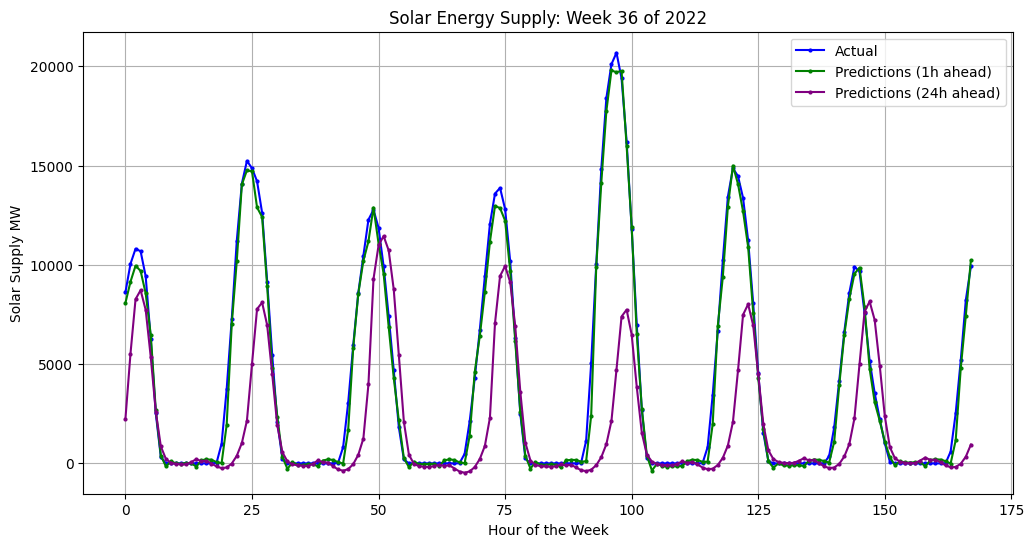

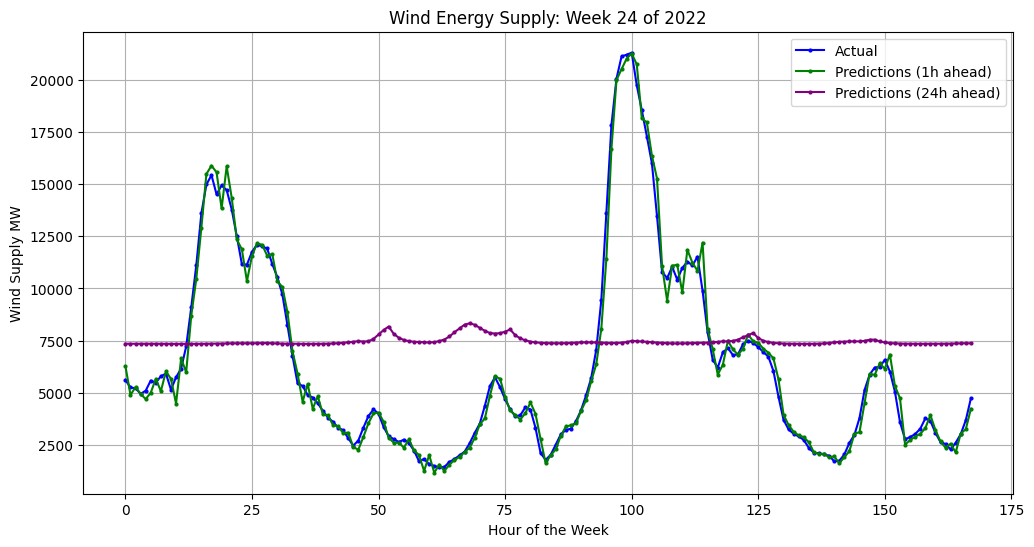

In [ ]:
plot_week(output_1h_solar, output_24h_solar, target_1h_solar, "Solar")
plot_week(output_1h_wind, output_24h_wind, target_1h_wind, "Wind")

In [ ]:
# Base timestamp
base_date = pd.Timestamp('2022-01-01 00:00')

# Generate a full range of hourly timestamps for the year 2022
timestamps = pd.date_range(start=base_date, periods=8760, freq='H')

In [ ]:
# Calculate offsets
offset_1h = 25
offset_24h = 72+23

# Align the timestamps for each type of prediction
timestamps_1h = timestamps[offset_1h:]
timestamps_24h = timestamps[offset_24h:]

# For a random week starting Monday
week_start = np.random.choice(np.where(timestamps.weekday == 0)[0])
week_timestamps = timestamps[week_start:week_start + 7*24]  # 7 days * 24 hours

# For a random day
day_start = np.random.randint(0, len(timestamps) - 24)
day_timestamps = timestamps[day_start:day_start + 24]  # 24 hours


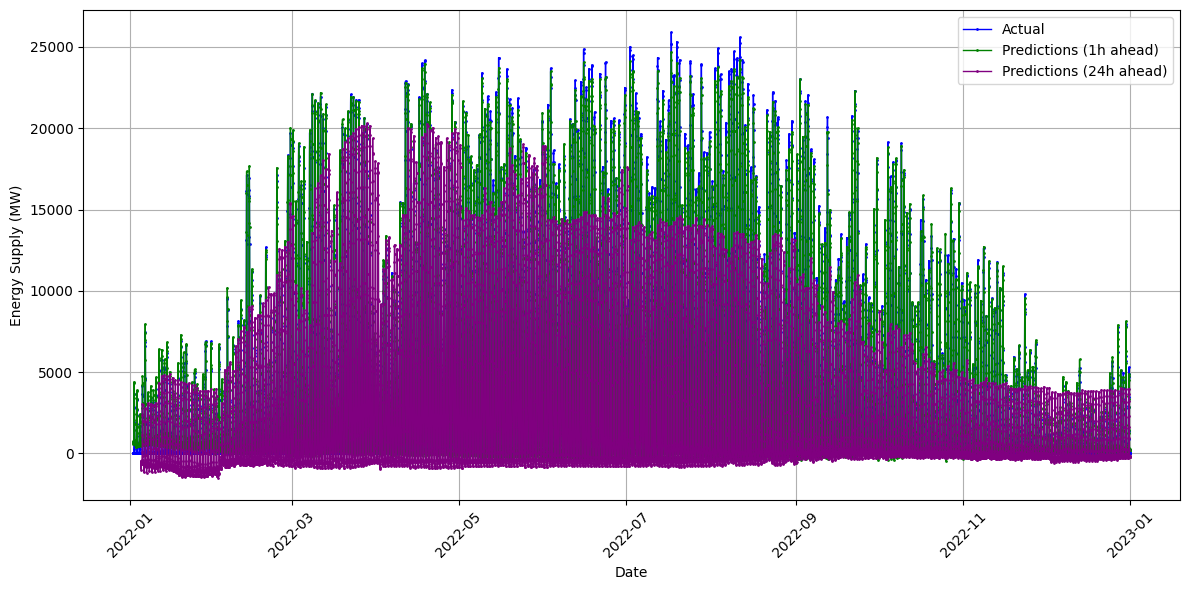

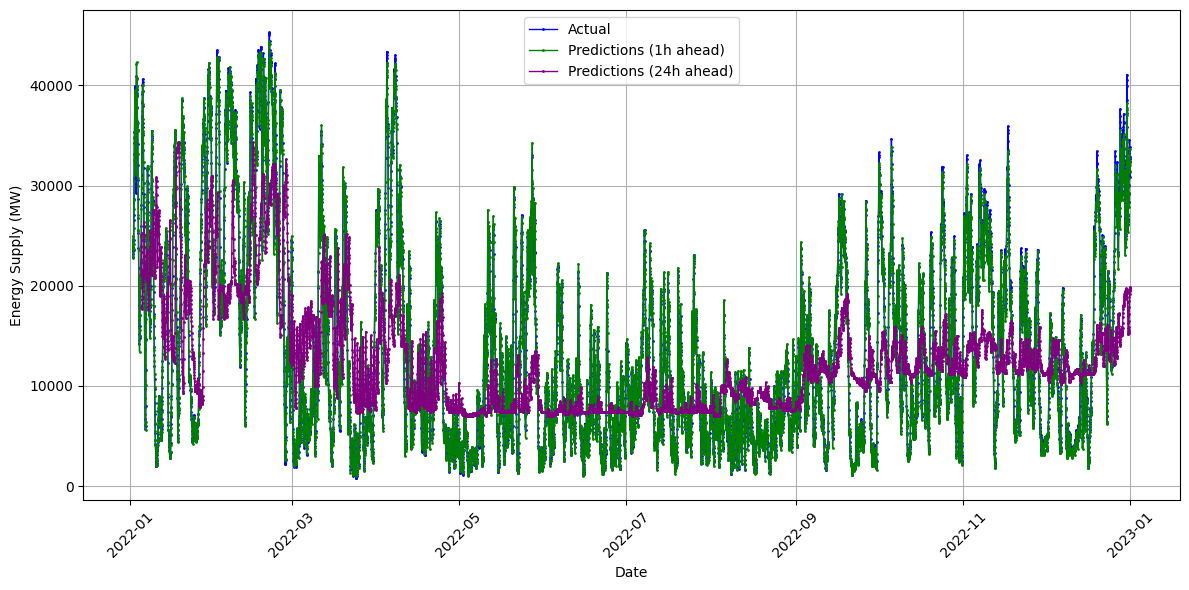

In [ ]:
def plot_predictions(ts_1h, ts_24h, output_1h, output_24h, target_1h):
    plt.figure(figsize=(12, 6))
    plt.plot(ts_1h, target_1h, "-o", color="b", label="Actual", markersize=1, linewidth=1)
    plt.plot(ts_1h, output_1h, "-o", color="g", label="Predictions (1h ahead)", markersize=1, linewidth=1)
    plt.plot(ts_24h, output_24h, "-o", color="purple", label="Predictions (24h ahead)", markersize=1, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Energy Supply (MW)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for Solar
plot_predictions(timestamps_1h, timestamps_24h, output_1h_solar, output_24h_solar, target_1h_solar)

# Plot for Wind
plot_predictions(timestamps_1h, timestamps_24h, output_1h_wind, output_24h_wind, target_1h_wind)


In [7]:
max_val = pd.read_csv('data\\training_data\\max_values.csv', delimiter=',').to_numpy()
min_val = pd.read_csv('data\\training_data\\min_values.csv', delimiter=',').to_numpy()
# we need min and max in row 5 col 1
max_pv = max_val[3][1]
min_pv = min_val[3][1]
max_wind = max_val[4][1]
min_wind = min_val[4][1]
print(max_pv, min_pv, max_wind, min_wind)  

9043.8125 0.0 11602.4375 32.3125


In [11]:
retrained_pv_output = np.genfromtxt('data/outputs_final/outputs_retrained_pv.csv', delimiter=',')
retrained_pv_target = np.genfromtxt('data/target_final/targets_retrained_pv.csv', delimiter=',')
retrained_wind_output = np.genfromtxt('data/outputs_final/outputs_wind_retrained.csv', delimiter=',')
retrained_wind_target = np.genfromtxt('data/target_final/targets_wind_retrained.csv', delimiter=',')
alt_pv_output = np.genfromtxt('data/outputs_final/outputs_alt_pv.csv', delimiter=',')
alt_pv_target = np.genfromtxt('data/target_final/targets_alt_pv.csv', delimiter=',')
alt_wind_output = np.genfromtxt('data/outputs_final/outputs_wind_alt.csv', delimiter=',')
alt_wind_target = np.genfromtxt('data/target_final/targets_wind_alt.csv', delimiter=',')

In [12]:
print('retrained pv output: ', retrained_pv_output.shape)
print('retrained wind output: ', retrained_wind_output.shape)
print('alt pv output: ', alt_pv_output.shape)
print('alt wind output: ', alt_wind_output.shape)
print('retrained pv target: ', retrained_pv_target.shape)
print('retrained wind target: ', retrained_wind_target.shape)
print('alt pv target: ', alt_pv_target.shape)
print('alt wind target: ', alt_wind_target.shape)

retrained pv output:  (8737, 2)
retrained wind output:  (8737,)
alt pv output:  (8737, 2)
alt wind output:  (8737,)
retrained pv target:  (8737, 2)
retrained wind target:  (8737,)
alt pv target:  (8737, 2)
alt wind target:  (8737,)


In [13]:
# ignore the first column of the data for pv
retrained_pv_output = retrained_pv_output[:,1]
alt_pv_output = alt_pv_output[:,1]
retrained_pv_target = retrained_pv_target[:,1]
alt_pv_target = alt_pv_target[:,1]

In [14]:
# number of nans in retrained pv output and target
# set nan to 0
retrained_pv_output[np.isnan(retrained_pv_output)] = 0
retrained_pv_target[np.isnan(retrained_pv_target)] = 0
retrained_wind_output[np.isnan(retrained_wind_output)] = 0
retrained_wind_target[np.isnan(retrained_wind_target)] = 0
alt_pv_output[np.isnan(alt_pv_output)] = 0
alt_pv_target[np.isnan(alt_pv_target)] = 0



In [15]:
rescaled_retrained_pv_output = invert_minmax_scaling(retrained_pv_output, min_pv, max_pv)
rescaled_retrained_pv_target = invert_minmax_scaling(retrained_pv_target, min_pv, max_pv)
rescaled_retrained_wind_output = invert_minmax_scaling(retrained_wind_output, min_wind, max_wind)
rescaled_retrained_wind_target = invert_minmax_scaling(retrained_wind_target, min_wind, max_wind)
rescaled_alt_pv_output = invert_minmax_scaling(alt_pv_output, min_pv, max_pv)
rescaled_alt_pv_target = invert_minmax_scaling(alt_pv_target, min_pv, max_pv)
rescaled_alt_wind_output = invert_minmax_scaling(alt_wind_output, min_wind, max_wind)
rescaled_alt_wind_target = invert_minmax_scaling(alt_wind_target, min_wind, max_wind)

In [16]:
#cut off at 0
rescaled_retrained_pv_output[rescaled_retrained_pv_output < 0] = 0
rescaled_retrained_pv_target[rescaled_retrained_pv_target < 0] = 0  
rescaled_retrained_wind_output[rescaled_retrained_wind_output < 0] = 0
rescaled_retrained_wind_target[rescaled_retrained_wind_target < 0] = 0
rescaled_alt_pv_output[rescaled_alt_pv_output < 0] = 0
rescaled_alt_pv_target[rescaled_alt_pv_target < 0] = 0
rescaled_alt_wind_output[rescaled_alt_wind_output < 0] = 0


In [17]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [18]:
print('rescaled RMSE')
print('retrained pv: ', rmse(rescaled_retrained_pv_output, rescaled_retrained_pv_target))
print('retrained wind: ', rmse(rescaled_retrained_wind_output, rescaled_retrained_wind_target))
print('alt pv: ', rmse(rescaled_alt_pv_output, rescaled_alt_pv_target))
print('alt wind: ', rmse(rescaled_alt_wind_output, rescaled_alt_wind_target))


rescaled RMSE
retrained pv:  170.70298175872955
retrained wind:  216.5651775122069
alt pv:  182.30368485983215
alt wind:  193.97737574927197


In [ ]:
print(rescaled_alt_pv_output.shape)

(8737,)


In [19]:
def plot_predictions(ts_1h, output_1h, target_1h):
    plt.figure(figsize=(12, 6))
    plt.plot(ts_1h, target_1h, "-o", color="blue", label="Actual", markersize=1, linewidth=1)
    plt.plot(ts_1h, output_1h, "-o", color="orange", label="Predictions (1h ahead)", markersize=1, linewidth=1)
    #plt.plot(ts_24h, output_24h, "-o", color="purple", label="Predictions (24h ahead)", markersize=1, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Energy Supply (MW)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [20]:
# Base timestamp
base_date = pd.Timestamp('2022-01-01 00:00')

# Generate a full range of hourly timestamps for the year 2022
timestamps = pd.date_range(start=base_date, periods=8760, freq='H')


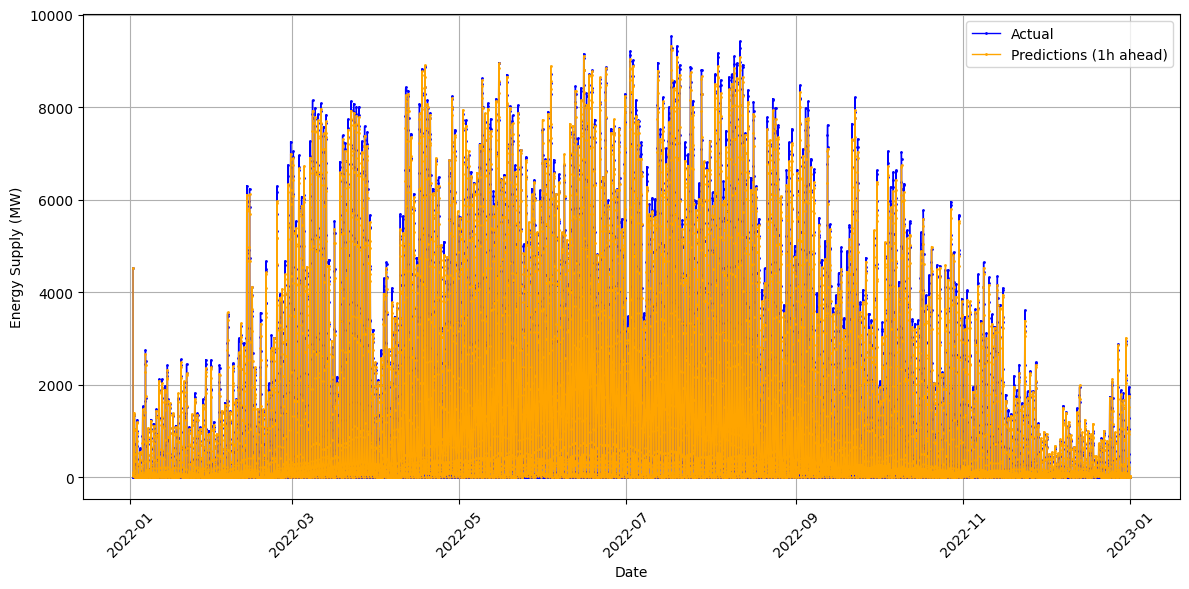

In [21]:
plot_predictions(timestamps[23:], rescaled_retrained_pv_output, rescaled_retrained_pv_target)

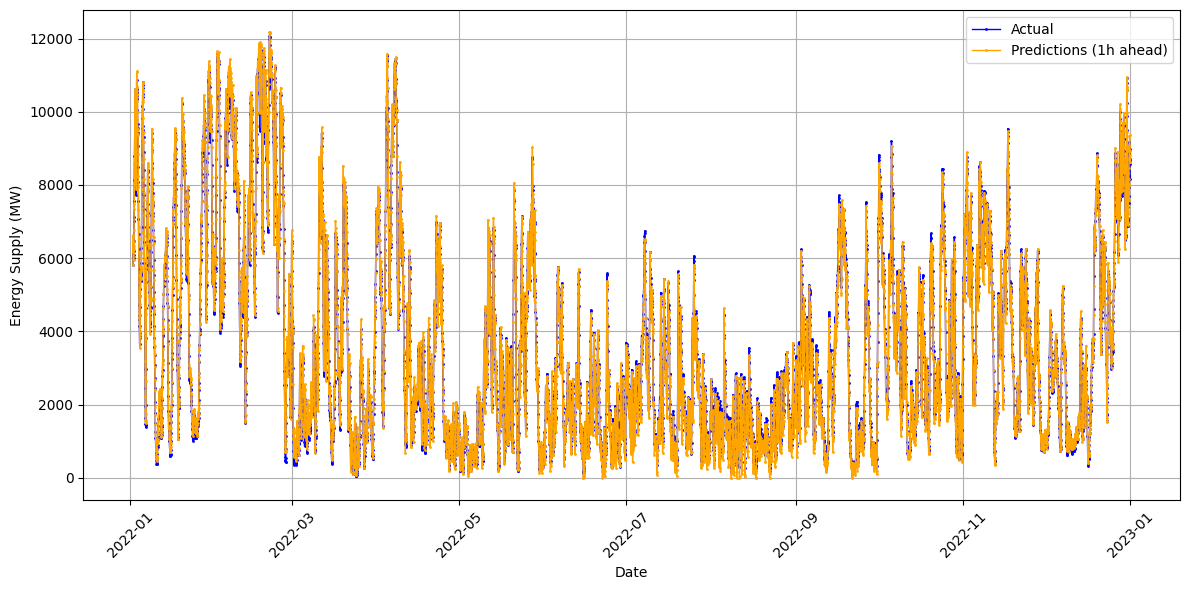

In [22]:
plot_predictions(timestamps[23:], rescaled_retrained_wind_output, rescaled_retrained_wind_target)

In [23]:
week_start = np.random.choice(range(len(timestamps) - 168))
print('week_start: ', week_start)

week_start:  7721


In [26]:
retrained_pv_24_output = np.genfromtxt('data/outputs_final/outputs_retrained_pv_24_2.csv', delimiter=',')
retrained_pv_24_target = np.genfromtxt('data/target_final/targets_retrained_pv_24_2.csv', delimiter=',')
alt_pv_24_output = np.genfromtxt('data/outputs_final/outputs_alt_pv_24_2.csv', delimiter=',')
alt_pv_24_target = np.genfromtxt('data/target_final/targets_alt_pv_24_2.csv', delimiter=',')

In [27]:
retrained_pv_24_output[np.isnan(retrained_pv_24_output)] = 0
retrained_pv_24_target[np.isnan(retrained_pv_24_target)] = 0
alt_pv_24_output[np.isnan(alt_pv_24_output)] = 0
alt_pv_24_target[np.isnan(alt_pv_24_target)] = 0

In [28]:
print('retrained pv 24 output: ', retrained_pv_24_output.shape)
print(timestamps.shape)
diff_24 = len(timestamps) - len(retrained_pv_24_output)

retrained pv 24 output:  (8666,)
(8760,)


In [29]:
retrained_pv_24_output = invert_minmax_scaling(retrained_pv_24_output, min_pv, max_pv)
retrained_pv_24_target = invert_minmax_scaling(retrained_pv_24_target, min_pv, max_pv)
alt_pv_24_output = invert_minmax_scaling(alt_pv_24_output, min_pv, max_pv)
alt_pv_24_target = invert_minmax_scaling(alt_pv_24_target, min_pv, max_pv)

In [31]:
retrained_pv_24_output[retrained_pv_24_output < 0] = 0
retrained_pv_24_target[retrained_pv_24_target < 0] = 0
alt_pv_24_output[alt_pv_24_output < 0] = 0
alt_pv_24_target[alt_pv_24_target < 0] = 0

In [32]:
print('rescaled RMSE')
print('retrained pv 24: ', rmse(retrained_pv_24_output, retrained_pv_24_target))
print('alt pv 24: ', rmse(alt_pv_24_output, alt_pv_24_target))


rescaled RMSE
retrained pv 24:  695.4562019591551
alt pv 24:  712.6183071409741


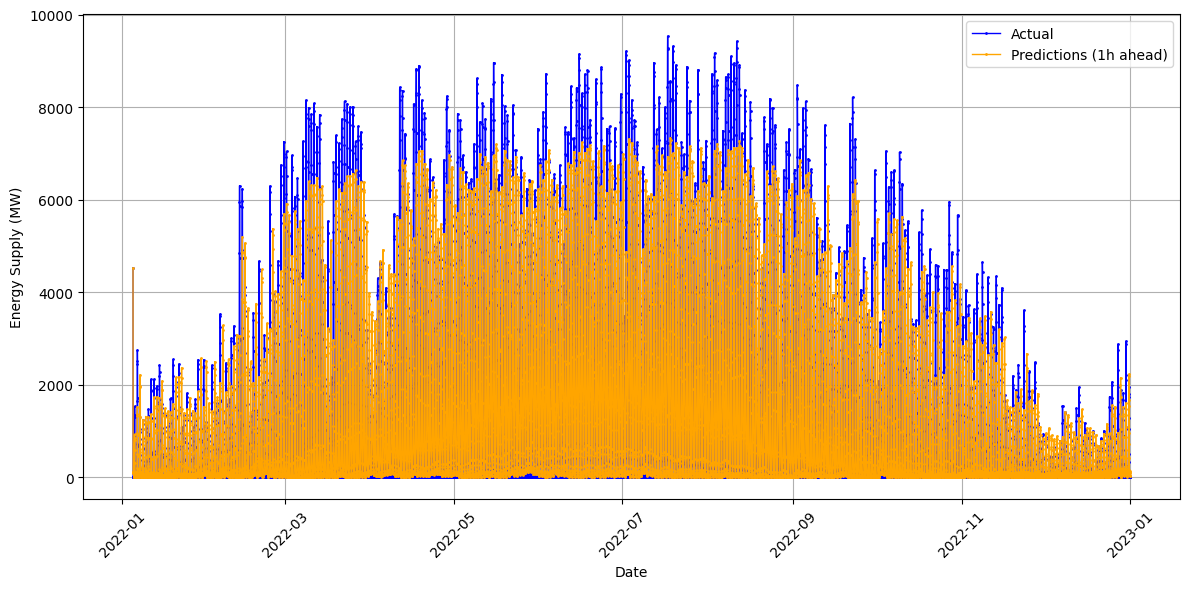

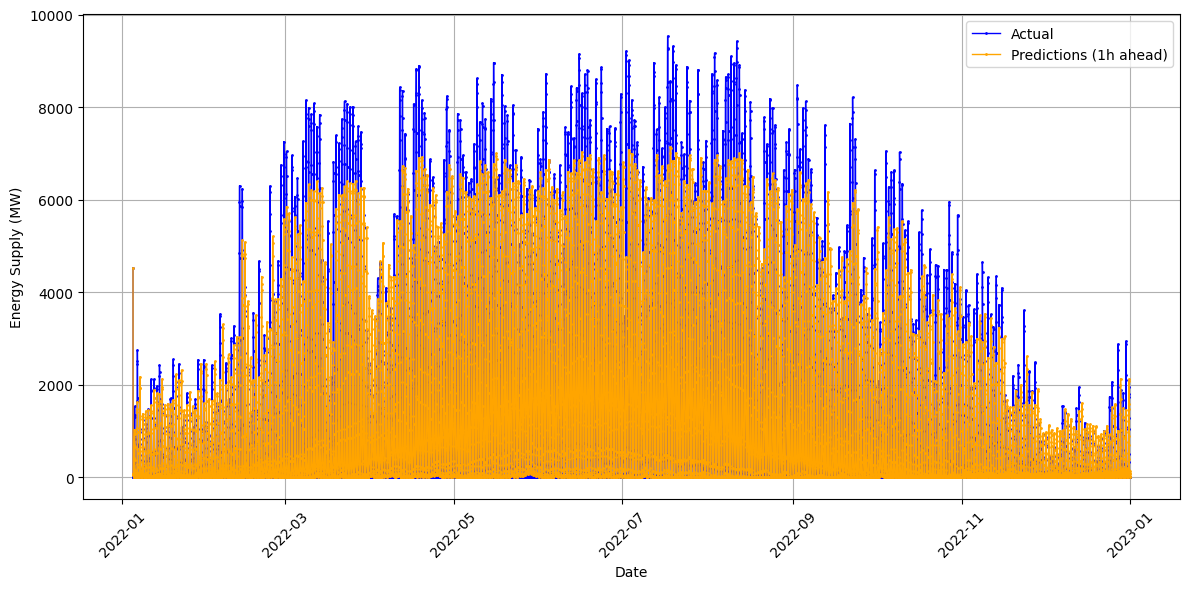

In [33]:
plot_predictions(timestamps[diff_24:], retrained_pv_24_output, retrained_pv_24_target)
plot_predictions(timestamps[diff_24:], alt_pv_24_output, alt_pv_24_target)

In [34]:
retrained_wind_output_24 = np.genfromtxt('data/outputs_final/outputs_retrained_wind_24.csv', delimiter=',')
retrained_wind_target_24 = np.genfromtxt('data/target_final/targets_retrained_wind_24.csv', delimiter=',')
alt_wind_output_24 = np.genfromtxt('data/outputs_final/outputs_alt_wind_24.csv', delimiter=',')
alt_wind_target_24 = np.genfromtxt('data/target_final/targets_alt_wind_24.csv', delimiter=',')


In [35]:
diff_24_wind = len(timestamps) - len(retrained_wind_output_24)


In [36]:
retrained_wind_output_24[np.isnan(retrained_wind_output_24)] = 0
retrained_wind_target_24[np.isnan(retrained_wind_target_24)] = 0
alt_wind_output_24[np.isnan(alt_wind_output_24)] = 0
alt_wind_target_24[np.isnan(alt_wind_target_24)] = 0

retrained_wind_output_24 = invert_minmax_scaling(retrained_wind_output_24, min_wind, max_wind)
retrained_wind_target_24 = invert_minmax_scaling(retrained_wind_target_24, min_wind, max_wind)
alt_wind_output_24 = invert_minmax_scaling(alt_wind_output_24, min_wind, max_wind)
alt_wind_target_24 = invert_minmax_scaling(alt_wind_target_24, min_wind, max_wind)


In [37]:
retrained_pv_24_output[retrained_pv_24_output < 0] = 0
retrained_pv_24_target[retrained_pv_24_target < 0] = 0
alt_pv_24_output[alt_pv_24_output < 0] = 0
alt_pv_24_target[alt_pv_24_target < 0] = 0

In [39]:
print('rescaled RMSE')
print('retrained wind 24: ', rmse(retrained_wind_output_24, retrained_wind_target_24))
print('alt wind 24: ', rmse(alt_wind_output_24, alt_wind_target_24))


rescaled RMSE
retrained wind 24:  2000.9855704311885
alt wind 24:  2030.2464541614559


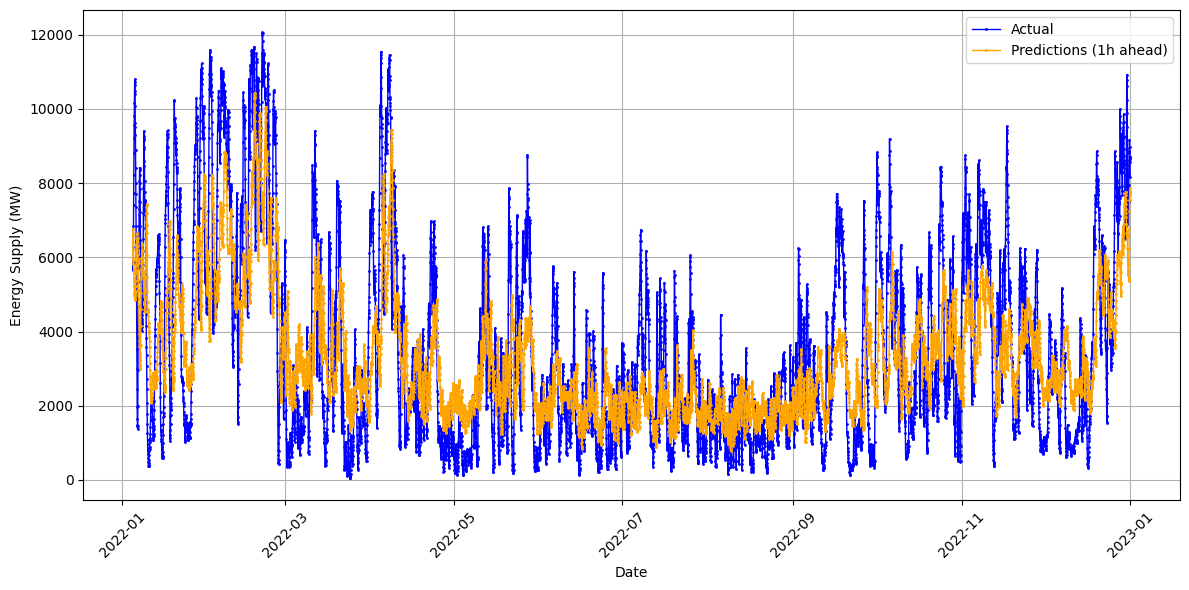

In [40]:
plot_predictions(timestamps[diff_24_wind:], retrained_wind_output_24, retrained_wind_target_24)



In [41]:
for i, data in enumerate(rescaled_retrained_pv_target):
    if data == 2364.2500139268745:
        print(i)

for i, data in enumerate(retrained_pv_24_target):
    if data == 2364.2500139268745:
        print(i)
# how often does this value appear
print(np.count_nonzero(rescaled_retrained_pv_target == 2364.2500139268745))
print(np.count_nonzero(retrained_pv_24_target == 2364.2500139268745))

7071
7000
1
1


In [91]:
# Function to plot actual and predicted data
def plot_predictions_week(timestamps, output, target, start_index, label):
    offset_1h = 24
    offset_24h = 72
    if label == "Predictions (1h ahead)":
        start_index_time = start_index + offset_1h
        end_index_time = start_index_time + 168
    else:
        start_index_time = start_index + offset_24h +24
    end_index = start_index + 168

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps[start_index_time:start_index_time + 168], target[start_index:end_index], "-o", color="blue", label="Actual", markersize=2, linewidth=2)
    plt.plot(timestamps[start_index_time:start_index_time + 168], output[start_index:end_index], "-o", color="orange", label=label, markersize=2, linewidth=2)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Energy Supply (MW)', fontsize=12)
    #increase legend font size
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

In [172]:



random_val = np.random.choice(rescaled_retrained_pv_target)
while np.count_nonzero(rescaled_retrained_pv_target == random_val) > 1:
    random_val = np.random.choice(rescaled_retrained_pv_target)
print(random_val)

index_1h = np.where(rescaled_retrained_pv_target == 6523.812479465625)[0][0]
index_24h = np.where(retrained_pv_24_target == 6523.812479465625)[0][0]
print(index_1h, index_24h)


3954.8124949584376
2607 2536


In [173]:
def plot_predictions_week(timestamps, hourly_output, daily_output, target1h, target24h, start_index, start_index24):
    offset_1h = 24
    offset_24h = 72

    # Calculate indices
    start_index_hourly = start_index + offset_1h
    start_index_daily = start_index24 + offset_24h + 23
    end_index1 = start_index + 168
    end_index24 = start_index24 + 168
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot Actual Data
    plt.plot(timestamps[start_index_hourly:start_index_hourly + 168], 
             target1h[start_index:end_index1], "-o", color="firebrick", 
             label="Actual", markersize=2, linewidth=2)
    
    # Plot Hourly Predictions
    plt.plot(timestamps[start_index_hourly:start_index_hourly + 168], 
             hourly_output[start_index:end_index1], "-o", color="forestgreen", 
             label="Predictions (1h ahead)", markersize=2, linewidth=2)
    
    # Plot Daily Predictions
    plt.plot(timestamps[start_index_daily:start_index_daily + 168], 
             daily_output[start_index24:end_index24], "-o", color="mediumslateblue", 
             label="Predictions (24h ahead)", markersize=2, linewidth=2)
    

    # Customize the plot
    plt.xlabel('Date', fontsize=11)
    plt.ylabel('Energy Supply (MW)', fontsize=11)
    plt.legend(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True)
    plt.xticks(rotation=45, fontsize=11)
    plt.tight_layout()
    
    # Show plot
    plt.show()


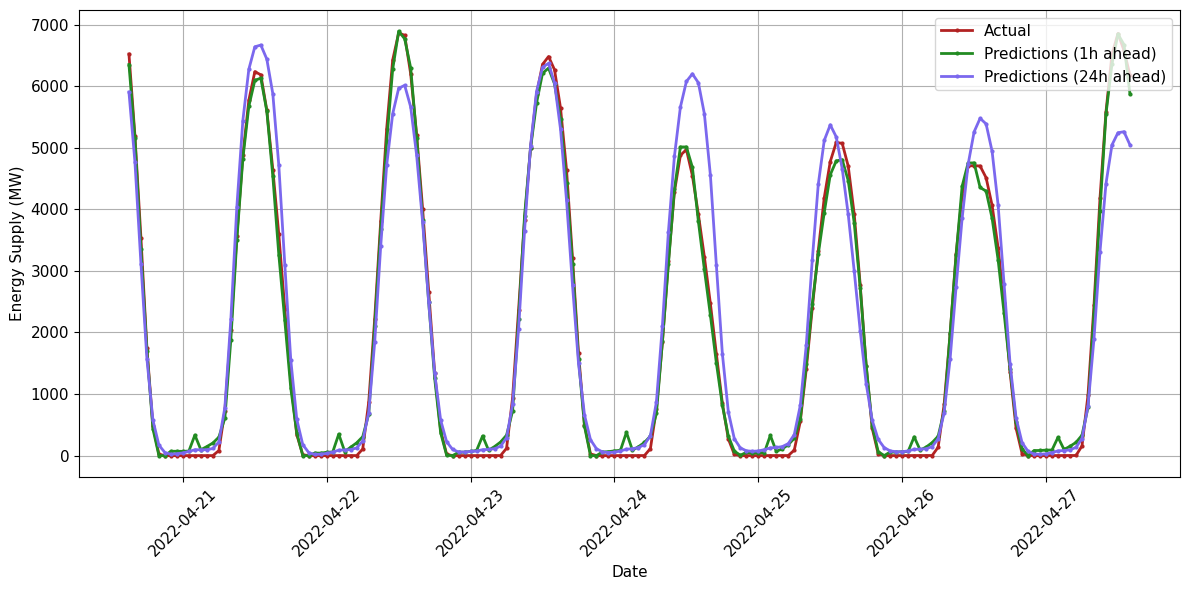

In [174]:
plot_predictions_week(timestamps, rescaled_retrained_pv_output, retrained_pv_24_output, rescaled_retrained_pv_target,retrained_pv_24_target, index_1h,index_24h)

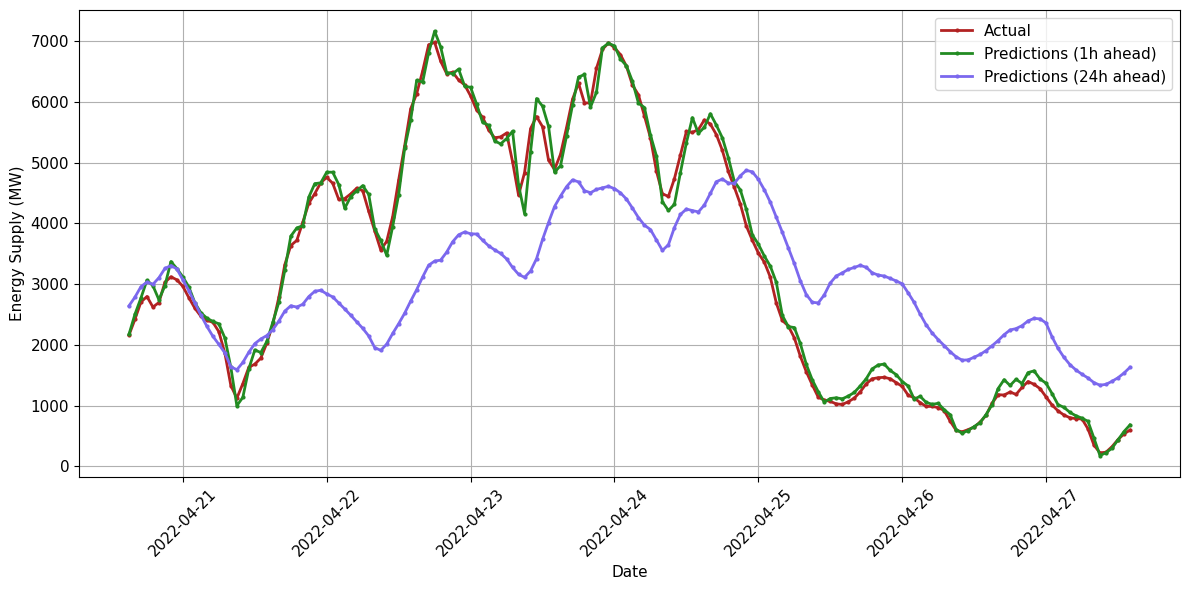

In [175]:
plot_predictions_week(timestamps, rescaled_retrained_wind_output, retrained_wind_output_24, rescaled_retrained_wind_target,retrained_wind_target_24, index_1h,index_24h)

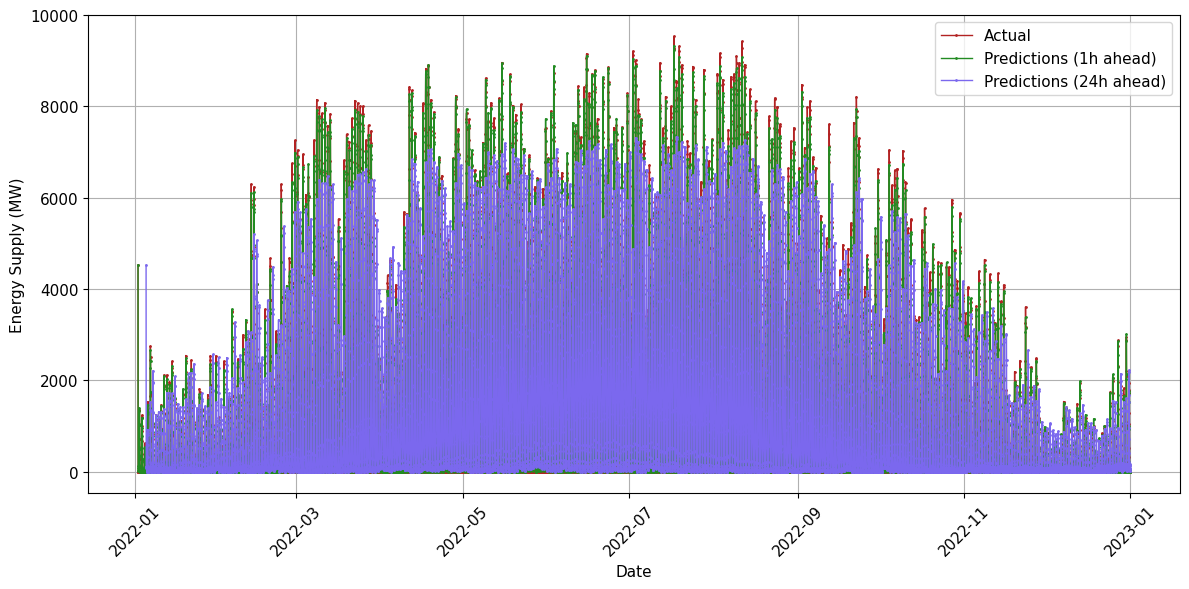

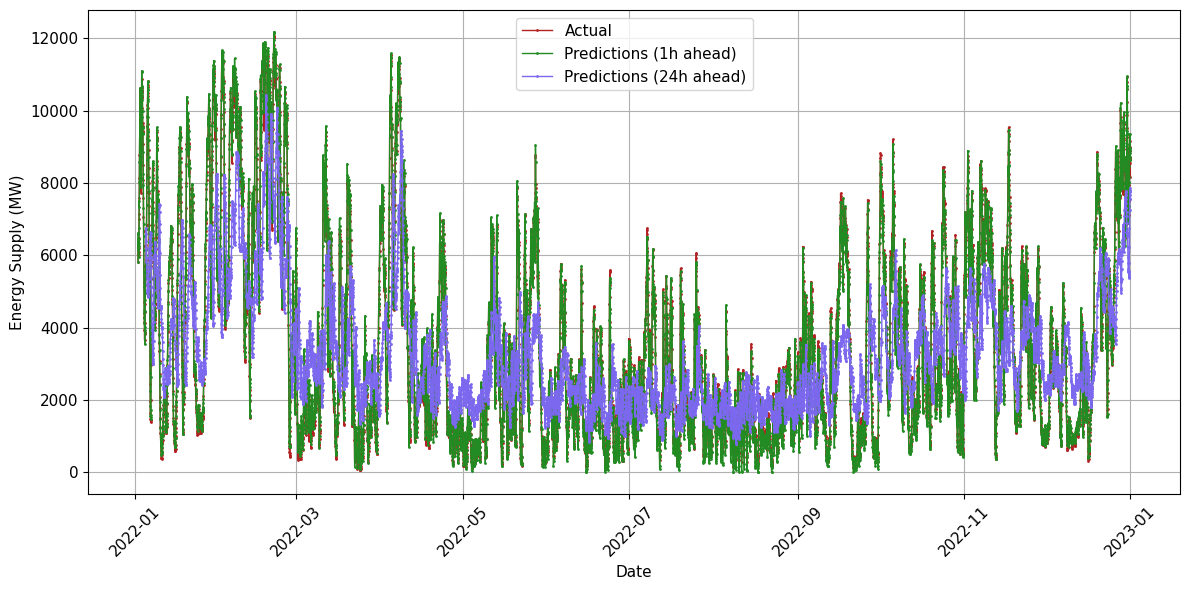

In [171]:
def plot_predictions(ts, output_1h, output24h, target):
    plt.figure(figsize=(12, 6))
    plt.plot(ts[23:], target, "-o", color="firebrick", label="Actual", markersize=1, linewidth=1)
    plt.plot(ts[23:], output_1h, "-o", color="forestgreen", label="Predictions (1h ahead)", markersize=1, linewidth=1)
    plt.plot(ts[diff_24:], output24h, "-o", color="mediumslateblue", label="Predictions (24h ahead)", markersize=1, linewidth=1)
    plt.xlabel('Date', fontsize=11)
    plt.ylabel('Energy Supply (MW)',fontsize=11)
    plt.legend(fontsize=11)
    plt.grid(True)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()
    
plot_predictions(timestamps, rescaled_retrained_pv_output, retrained_pv_24_output, rescaled_retrained_pv_target)   
plot_predictions(timestamps, rescaled_retrained_wind_output, retrained_wind_output_24, rescaled_retrained_wind_target) 